In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline
%aimport tgcn_model
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import torch
from torchvision import transforms
from pytorch_i3d import InceptionI3d
from tgcn_model import GCN_muti_att, GraphConvolution_att
import json
from keytotext import pipeline

c:\Users\mloet\anaconda3\envs\torch10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


In [2]:
mp_holistic = mp.solutions.holistic 
mp_drawing = mp.solutions.drawing_utils

In [3]:
def midpoint(p1, p2):
        return np.array([(p1[0]+p2[0])/2, (p1[1]+p2[1])/2])

In [4]:
def midpoint3d(p1, p2):
        return np.array([(p1[0]+p2[0])/2, (p1[1]+p2[1])/2, (p1[2]+p2[2])/2])

In [5]:
def project(point):
  px, py, pz = point

  x1, y1 = (0, 0)
  x2, y2 = (0, 0)

  if not any(c > 1 or c < 0 for c in point[:2]):
    return point
  if(px < 0 and py < 0):
    return np.array([0, 0, pz])
  if(px < 0 and py > 1):
    return np.array([0, 1, pz])
  if(px > 1 and py > 1):
    return np.array([1, 1, pz])
  if(px > 1 and py < 0):
    return np.array([1, 0, pz])
  if(px < 0):
    x1, y1 = (0, 1)
    x2, y2 = (0, 0)
  if(px > 1):
    x1, y1 = (1, 1)
    x2, y2 = (1, 0)
  if(py < 0):
    x1, y1 = (1, 0)
    x2, y2 = (0, 0)
  if(py > 1):
    x1, y1 = (0, 1)
    x2, y2 = (1, 1)

  dx = x2 - x1
  dy = y2 - y1
  
  t = ((px - x1) * dx + (py - y1) * dy) / (dx**2 + dy**2)
  
  projected_x = x1 + t * dx
  projected_y = y1 + t * dy
  
  return np.array([projected_x, projected_y, pz])

In [6]:
(project([-1, 0.4, 0])-0.5)*2

array([-1. , -0.2, -1. ])

In [7]:
def extract_keypoints_3d(results, prev):
    pose = np.array([project([landmark.x, landmark.y, landmark.z]) for landmark in results.pose_landmarks.landmark]) if results.pose_landmarks else np.zeros((33,3))
    neck = midpoint3d(pose[11], pose[12])
    hips = midpoint3d(pose[23], pose[24])
    pose = np.append(pose, np.array([neck, hips]), axis = 0)[[0, 33, 12, 14, 16, 11, 13, 15, 34, 5, 2, 8, 7], :]
    drw = pose[4] - prev[4]
    dlw = pose[7] - prev[7]
    lh = np.array([project([landmark.x, landmark.y, landmark.z]) for landmark in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else prev[13:34] + dlw
    rh = np.array([project([landmark.x, landmark.y, landmark.z]) for landmark in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else prev[34:] + drw
    kp = np.concatenate([pose, lh, rh])
    return transform_points_to_xy_plane(kp, calculate_normal_vector(kp[2], kp[5], kp[8]))

In [8]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [9]:
def extract_keypoints_max(results):
    keypoints = []
    if results.pose_landmarks:
        keypoints.append(np.array([[res.x, res.y] for res in results.pose_landmarks.landmark]))
    if results.face_landmarks:
        keypoints.append(np.array([[res.x, res.y] for res in results.face_landmarks.landmark]))
    if results.left_hand_landmarks:
        keypoints.append(np.array([[res.x, res.y] for res in results.left_hand_landmarks.landmark]))
    if results.right_hand_landmarks:
        keypoints.append(np.array([[res.x, res.y] for res in results.right_hand_landmarks.landmark]))
    return np.concatenate(keypoints) if len(keypoints)>0 else np.array([])

In [10]:
def compute_difference(x):
    diff = []

    for i, xx in enumerate(x):
        temp = []
        for j, xxx in enumerate(x):
            if i != j:
                temp.append(xx - xxx)

        diff.append(temp)

    return diff


In [11]:
def extract_keypoints(results):
    pose = np.array([[landmark.x, landmark.y] for landmark in results.pose_landmarks.landmark]) if results.pose_landmarks else np.zeros((33,2))
    neck = midpoint(pose[11], pose[12])
    hips = midpoint(pose[23], pose[24])
    pose = np.append(pose, np.array([neck, hips]), axis = 0)[[0, 33, 12, 14, 16, 11, 13, 15, 34, 5, 2, 8, 7], :]
    for i, point in enumerate(pose):
        if any(x > 1 or x < 0 for x in point):
            pose[i] = [0, 0]
    lh = np.array([[landmark.x, landmark.y] for landmark in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.zeros((21,2))
    rh = np.array([[landmark.x, landmark.y] for landmark in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else np.zeros((21,2))

    return torch.FloatTensor((np.concatenate([pose, lh, rh])-0.5)*2)

In [12]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections
    

In [13]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
    #                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                          ) 
    # # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [14]:
def generate_bounding_box(keypoints, frame):
  transform = transforms.Compose([
          transforms.ToPILImage(),
          transforms.Resize((224, 325)),
          transforms.CenterCrop(224),
          transforms.ToTensor()
      ])
  input_img = transform(frame)
  if keypoints.size > 0:
    H, W, _ = frame.shape
    x_vals = []
    y_vals = []
    for lm in keypoints:
      x = int(lm[0] * W)
      y = int(lm[1] * H)
      x_vals.append(x)
      y_vals.append(y)
          
      min_x = min(x_vals) - 60 if min(x_vals) - 60 >= 0 else 0
      max_x = max(x_vals) + 60 if max(x_vals) + 60 <= W else W
      min_y = min(y_vals) - 60 if min(y_vals) - 60 >= 0 else 0
      max_y = max(y_vals) + 60 if max(y_vals) + 60 <= H else H


      transform = transforms.Compose([
          transforms.ToPILImage(),
          transforms.Lambda(lambda img: transforms.functional.crop(img, min_y, min_x, max_y - min_y, max_x - min_x)),
          transforms.Resize((224, 224)),
          transforms.ToTensor()
      ])

      input_img = transform(frame)
  return input_img

      # results = pose.process(frame).pose_landmarks
      # if results:
      #   # keypoints = np.array([[res.x, res.y] for res in results.landmark])
      #   rs = results.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
      #   ls = results.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER.value]

      # mp_drawing.draw_landmarks(frame, results, mp.solutions.pose.POSE_CONNECTIONS,
      #                          mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
      #                          mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
      #                          ) 
      # cv2.rectangle(image, (min_x, min_y), (max_x, max_y), (0, 0, 0), 4)

In [15]:
def vid_to_tensor(video_path, start=0, num=-1):
  vidcap = cv2.VideoCapture(video_path)
  vidcap.set(cv2.CAP_PROP_POS_FRAMES, start)
  if num == -1:
    num = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

  frames = []
  for offset in range(num):
    success, img = vidcap.read()
    if not success:
      continue

    w, h, c = img.shape
    sc = 224 / w
    img = cv2.resize(img, dsize=(0, 0), fx=sc, fy=sc)
    img = (img / 255.) * 2 - 1
    img = transforms.CenterCrop(224)(torch.Tensor(img.transpose([2, 0, 1])))
    frames.append(img)
  
  return torch.from_numpy(np.expand_dims(np.asarray(frames, dtype=np.float32).transpose([1, 0, 2, 3]), axis = 0))

In [16]:
def vid_to_mp(video_path, start=0, num=-1):
  vidcap = cv2.VideoCapture(video_path)
  vidcap.set(cv2.CAP_PROP_POS_FRAMES, start)
  if num == -1:
    num = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

  frames = []
  prev = np.zeros((55, 3))
  mp_holistic = mp.solutions.holistic 
  with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for offset in range(num):
      success, img = vidcap.read()
      if not success:
        continue

      w, h, c = img.shape

      image, results = mediapipe_detection(img, holistic)

      keypoints = extract_keypoints_3d(results, prev)
      prev = keypoints
      frames.append(keypoints)
    
  return frames

In [17]:
def tensor_to_imgs(input):
  img = np.array(input[0].flip(0))
  img = (img + 1) / 2
  return img.transpose([1, 2, 3, 0])

In [18]:
def from_video(vid_path, model, labels):
  sentence = []
  threshold = 0.05

  video = vid_to_tensor(vid_path)
  frames = video.shape[2]
  i = 0
  while i < frames:
    end1 = 30 if i + 30 < frames else frames - i
    end2 = 60 if i + 60 < frames else frames - i

    word = ''

    if end1 > 10:
      chunk1 = video[:, :, i:i+end1, :, :]
      per_frame_logits1 = model(chunk1)
      predictions1 = torch.max(per_frame_logits1, dim=2)[0]
      p1, k1 = torch.nn.functional.softmax(predictions1, dim = 1).topk(1, dim = 1)
      if(p1[0,0].item()>threshold):
        print('1')
        i = i+end1
        word = labels[k1[0,0].item()]
    if end2 > 10 and word != '':
      chunk2 = video[:, :, i:i+end2, :, :]
      per_frame_logits2 = model(chunk2)
      predictions2 = torch.max(per_frame_logits2, dim=2)[0]
      p2, k2 = torch.nn.functional.softmax(predictions2, dim = 1).topk(1, dim = 1)
      if(p2[0,0].item()>threshold):
        print('2')
        i = i+end2
        word = labels[k2[0,0].item()]
    if word == '':
      i+=5
    else:
      sentence.append(word)
      
    if(end1 != 30):
      break

  return sentence

In [19]:
def from_recording(model, labels):
  sequence = []
  record = False
  cap = cv2.VideoCapture(0)
  
  while cap.isOpened():
    success, frame = cap.read()
    if record:
      img = frame
      w, h, c = img.shape
      sc = 224 / w
      img = cv2.resize(img, dsize=(0, 0), fx=sc, fy=sc)
      img = (img / 255.) * 2 - 1
      img = transforms.CenterCrop(224)(torch.Tensor(img.transpose([2, 0, 1])))
      sequence.append(img)

    cv2.imshow('OpenCV Feed', frame)

    key = cv2.waitKey(10)
    if key & 0xFF == ord(' '):
      if not record:
        print("Recording...")
        record = True
      else:
        print("End recording")
        break
    if key & 0xFF == ord('q'):
      break
  cap.release()
  cv2.destroyAllWindows()

  video = torch.from_numpy(np.expand_dims(np.asarray(sequence, dtype=np.float32).transpose([1, 0, 2, 3]), axis = 0))

  sentence = []
  threshold = 0.05
  frames = video.shape[2]
  i = 0
  while i < frames:
    end1 = 30 if i + 30 < frames else frames - i
    end2 = 60 if i + 60 < frames else frames - i

    word = ''

    if end1 > 10:
      chunk1 = video[:, :, i:i+end1, :, :]
      per_frame_logits1 = model(chunk1)
      predictions1 = torch.max(per_frame_logits1, dim=2)[0]
      p1, k1 = torch.nn.functional.softmax(predictions1, dim = 1).topk(1, dim = 1)
      if(p1[0,0].item()>threshold):
        i = i+end1
        word = labels[k1[0,0].item()]
    if end2 > 10 and word != '':
      chunk2 = video[:, :, i:i+end2, :, :]
      per_frame_logits2 = model(chunk2)
      predictions2 = torch.max(per_frame_logits2, dim=2)[0]
      p2, k2 = torch.nn.functional.softmax(predictions2, dim = 1).topk(1, dim = 1)
      if(p2[0,0].item()>threshold):
        i = i+end2
        word = labels[k2[0,0].item()]
    if word == '':
      i+=5
    else:
      sentence.append(word)

    
    if(end1 != 30):
      break

  return sentence

In [20]:
def read_pose_file(filepath):
    body_pose_exclude = {9, 10, 11, 12, 13, 14, 19, 20, 21, 22, 23, 24}

    try:
        content = json.load(open(filepath))["people"][0]
    except IndexError:
        return None

    path_parts = os.path.split(filepath)

    frame_id = path_parts[1][:11]
    vid = os.path.split(path_parts[0])[-1]

    save_to = os.path.join('/home/dxli/workspace/nslt/code/Pose-GCN/posegcn/features', vid)

    try:
        ft = torch.load(os.path.join(save_to, frame_id + '_ft.pt'))

        xy = ft[:, :2]
        # angles = torch.atan(ft[:, 110:]) / 90
        # ft = torch.cat([xy, angles], dim=1)
        return xy

    except FileNotFoundError:
        print(filepath)
        body_pose = content["pose_keypoints_2d"]
        left_hand_pose = content["hand_left_keypoints_2d"]
        right_hand_pose = content["hand_right_keypoints_2d"]

        body_pose.extend(left_hand_pose)
        body_pose.extend(right_hand_pose)

        x = [v for i, v in enumerate(body_pose) if i % 3 == 0 and i // 3 not in body_pose_exclude]
        y = [v for i, v in enumerate(body_pose) if i % 3 == 1 and i // 3 not in body_pose_exclude]
        # conf = [v for i, v in enumerate(body_pose) if i % 3 == 2 and i // 3 not in body_pose_exclude]

        x = 2 * ((torch.FloatTensor(x) / 256.0) - 0.5)
        y = 2 * ((torch.FloatTensor(y) / 256.0) - 0.5)
        # conf = torch.FloatTensor(conf)

        x_diff = torch.FloatTensor(compute_difference(x)) / 2
        y_diff = torch.FloatTensor(compute_difference(y)) / 2

        zero_indices = (x_diff == 0).nonzero()

        orient = y_diff / x_diff
        orient[zero_indices] = 0

        xy = torch.stack([x, y]).transpose_(0, 1)

        ft = torch.cat([xy, x_diff, y_diff, orient], dim=1)

        path_parts = os.path.split(filepath)

        frame_id = path_parts[1][:11]
        vid = os.path.split(path_parts[0])[-1]

        # save_to = os.path.join('code/Pose-GCN/posegcn/features', vid)
        # if not os.path.exists(save_to):
        #     os.mkdir(save_to)
        # torch.save(ft, os.path.join(save_to, frame_id + '_ft.pt'))

        xy = ft[:, :2]
        # angles = torch.atan(ft[:, 110:]) / 90
        # ft = torch.cat([xy, angles], dim=1)
        #
        return xy

In [21]:
def sequential_sampling(frame_start, frame_end, num_samples):
    """Keep sequentially ${num_samples} frames from the whole video sequence by uniformly skipping frames."""
    num_frames = frame_end - frame_start + 1

    frames_to_sample = []
    if num_frames > num_samples:
        frames_skip = set()

        num_skips = num_frames - num_samples
        interval = num_frames // num_skips

        for i in range(frame_start, frame_end + 1):
            if i % interval == 0 and len(frames_skip) <= num_skips:
                frames_skip.add(i)

        for i in range(frame_start, frame_end + 1):
            if i not in frames_skip:
                frames_to_sample.append(i)
    else:
        frames_to_sample = list(range(frame_start, frame_end + 1))

    return frames_to_sample

In [22]:
def load_poses(video_id, frame_start, frame_end, num_samples):
        """ Load frames of a video. Start and end indices are provided just to avoid listing and sorting the directory unnecessarily.
         """
        poses = []
        
        frames_to_sample = sequential_sampling(frame_start, frame_end, num_samples)

        for i in frames_to_sample:
            pose_path = os.path.join(os.path.join('..', '..', 'WLASL', 'data', 'pose_per_individual_videos'), video_id, 'image_{}_keypoints.json'.format(str(i).zfill(5)))
            # pose = cv2.imread(frame_path, cv2.COLOR_BGR2RGB)
            pose = read_pose_file(pose_path)

            if pose is not None:
                poses.append(pose)
            else:
                try:
                    poses.append(poses[-1])
                except IndexError:
                    print(pose_path)

        pad = None

        # if len(frames_to_sample) < num_samples:
        # if len(poses) < num_samples:
        #     num_padding = num_samples - len(frames_to_sample)
        #     last_pose = poses[-1]
        #     pad = last_pose.repeat(1, num_padding)

        # poses_across_time = torch.cat(poses, dim=1)
        # if pad is not None:
        #     poses_across_time = torch.cat([poses_across_time, pad], dim=1)

        return poses

In [23]:
def calculate_normal_vector(point1, point2, point3):
    vector1 = np.array(point2) - np.array(point1)
    vector2 = np.array(point3) - np.array(point1)
    normal_vector = np.cross(vector1, vector2)
    magnitude = np.linalg.norm(normal_vector)
    
    return normal_vector/magnitude

In [24]:
def transform_points_to_xy_plane(points, normal_vector):
    # Normalize the normal vector
    normal_vector = normal_vector / np.linalg.norm(normal_vector)
    
    # Calculate the rotation matrix to align the normal vector with the z-axis
    z_axis = np.array([0, 0, 1])
    if np.allclose(normal_vector, z_axis):
        # If the normal vector is already aligned with the z-axis, no rotation is needed
        rotation_matrix = np.eye(3)
    else:
        # Calculate the rotation axis and angle
        rotation_axis = np.cross(normal_vector, z_axis)
        rotation_angle = np.arccos(np.dot(normal_vector, z_axis))
        
        # Create the rotation matrix
        rotation_matrix = np.eye(3) + np.sin(rotation_angle) * np.array([[0, -rotation_axis[2], rotation_axis[1]],
                                                                        [rotation_axis[2], 0, -rotation_axis[0]],
                                                                        [-rotation_axis[1], rotation_axis[0], 0]]) + \
                                         (1 - np.cos(rotation_angle)) * np.outer(rotation_axis, rotation_axis)
    
    # Apply the rotation matrix to the original points
    transformed_points = np.dot(rotation_matrix, points.T).T
    
    return transformed_points

In [90]:
# posefile = read_pose_file(os.path.join('..', '..', 'WLASL', 'data', 'pose_per_individual_videos', '05729', 'image_00010_keypoints.json'))
vid = vid_to_mp(os.path.join('..', '..', 'WLASL', 'data', 'WLASL2000', '00339.mp4'))
# vidw = load_poses('05729', 1, 45, 50)

In [46]:
%aimport stream_utils 

def from_stream(cmodel, labels):
  fill_mask = transformers.pipeline("fill-mask", model="distilroberta-base")
  tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
  nlp = GPT2LMHeadModel.from_pretrained("gpt2")
  display_sentence = ""
  sequence = []
  sentence = []
  threshold = 0.9
  prev = np.zeros((55, 3))
  mp_holistic = mp.solutions.holistic 
  cap = cv2.VideoCapture(0)
  with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
      success, frame = cap.read()
      
      image = frame
      w, h, c = image.shape

      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image.flags.writeable = False                  
      results = holistic.process(image)                 
      image.flags.writeable = True                   
      image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 

      keypoints = stream_utils.extract_keypoints_3d(results, prev)
      prev = keypoints

      sequence.append(torch.FloatTensor((keypoints[:, (0, 1)]-0.5)*2))
      sequence = sequence[-50:]
      
      if len(sequence) == 50:
        input = torch.cat(sequence,  dim = 1).unsqueeze(0)
        per_frame_logits = cmodel(input)
        p, k  = torch.nn.functional.softmax(per_frame_logits, dim = 1).topk(10, dim = 1)
        if p[0,0].item()>threshold: 
          word = labels[k[0,0].item()]
          input_ids = tokenizer.encode(display_sentence, return_tensors="pt")
          output = nlp.generate(input_ids, max_length=1, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)
          predicted_word = tokenizer.decode(output[0][-1], skip_special_tokens=True)[1:]
          for i, n in enumerate(k[0]):
            if labels[n.item()]==predicted_word:
              word = predicted_word

          if len(sentence) > 0: 
            if word != sentence[-1]:
              sentence.append(word)
              fill = fill_mask(display_sentence + f' <mask> {word}')[0]
              display_sentence = fill['sequence'] if fill['score'] > 0.05 else f"{display_sentence} {word}"
          else:
            sentence.append(word)

      cv2.rectangle(image, (0,0), (640, 40), (0, 0, 0), -1)
      cv2.putText(image, display_sentence, (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
      cv2.imshow('OpenCV Feed', image)

      key = cv2.waitKey(10)
      if key & 0xFF == ord('q'):
        break
  cap.release()
  cv2.destroyAllWindows()
  return sentence

In [23]:
weights = os.path.join('model', '2000words.pt')
i3d = InceptionI3d(400, in_channels=3)
i3d.replace_logits(2000)
i3d.load_state_dict(torch.load(weights, map_location=torch.device('cpu'))) 
i3d.eval()
with open('labels.txt', 'r') as file:
    labels = list(map(str.strip, file.readlines()))

In [40]:
# %aimport tgcn_model 
with open('labels.txt', 'r') as file:
    labels = list(map(str.strip, file.readlines()))
tgcn = GCN_muti_att(input_feature=100, hidden_feature=64, num_class=100, p_dropout=0.3, num_stage=20)
tgcn.load_state_dict(torch.load(os.path.join('model', '100gcn.pth'), map_location=torch.device('cpu')))
tgcn.eval()
# model = torch.nn.Sequential(GraphConvolution_att(100, 100, 55, 53), tgcn)#, torch.nn.BatchNorm1d(55 * 100))

GCN_muti_att(
  (gc1): GraphConvolution_att (100 -> 64)
  (bn1): BatchNorm1d(3520, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcbs): ModuleList(
    (0-19): 20 x GC_Block (64 -> 64)
  )
  (do): Dropout(p=0.3, inplace=False)
  (act_f): Tanh()
  (fc_out): Linear(in_features=64, out_features=100, bias=True)
)

In [74]:
pose = torch.FloatTensor([project([landmark.x, landmark.y, landmark.z]) for landmark in results.pose_landmarks.landmark]) if results.pose_landmarks else torch.zeros((33,3))
neck = midpoint3d(pose[11], pose[12]).unsqueeze(0)
hips = midpoint3d(pose[23], pose[24]).unsqueeze(0)
pose = torch.cat((pose, neck, hips), 0)[[0, 33, 12, 14, 16, 11, 13, 15, 34, 5, 2, 8, 7], :]
drw = pose[4] - prev[4]
dlw = pose[7] - prev[7]
lh   = np.array([project([landmark.x, landmark.y, landmark.z]) for landmark in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else prev[13:34] + dlw
rh = torch.FloatTensor([project([landmark.x, landmark.y, landmark.z]) for landmark in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else prev[34:] + drw
kp = torch.cat([pose, lh, rh])
kp = transform_points_to_xy_plane(kp, calculate_normal_vector(kp[2], kp[5], kp[8]))

TypeError: expected Tensor as element 1 in argument 0, but got numpy.ndarray

In [74]:
input_ids

tensor([[14108,  3797, 14720]])

In [71]:
bool(results.left_hand_landmarks)

True

In [37]:
per_frame_logits = model(input)

In [61]:
p, k  = torch.nn.functional.softmax(per_frame_logits, dim = 1).topk(10, dim = 1)

In [64]:
for i, n in enumerate(k[0]):
  

SyntaxError: cannot assign to function call (1342701995.py, line 1)

In [23]:
per_frame_logits = tgcn(input)

: 

In [65]:
sentence = from_stream(tgcn, labels)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [66]:
sentence

['like', 'wrong', 'need', 'like', 'need', 'pizza', 'like']

(0.0, 1.0)

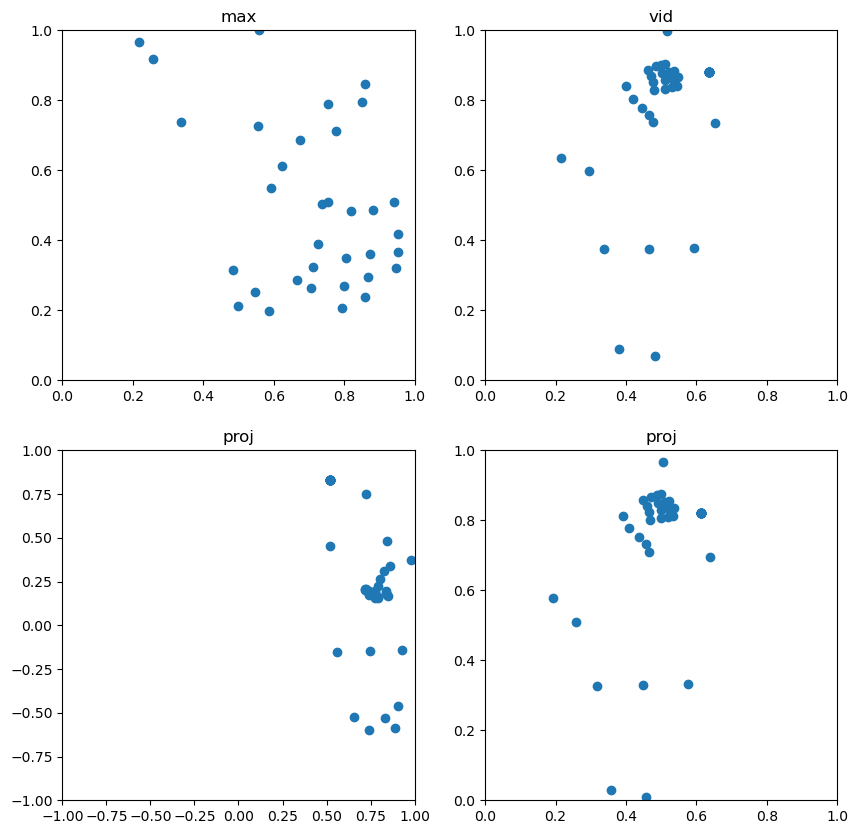

In [100]:
f = 30
p = 55

nkp = transform_points_to_xy_plane(keypoints, calculate_normal_vector(keypoints[2], keypoints[5], keypoints[8]))
nkpv = transform_points_to_xy_plane(vid[f], calculate_normal_vector(vid[f][2], vid[f][5], vid[f][8]))
#[[0, 33, 12, 14, 16, 11, 13, 15, 34, 5, 2, 8, 7], :]

fig, axes = plt.subplots(2, 2, figsize=(10, 10)) 

# Plot 1
axes[0, 0].scatter(x = keypoints[:, 0][:p], y = keypoints[:, 1][:p])
axes[0, 0].set_title('max')
axes[0, 0].set_xlim(0, 1)  # Set x-axis limits
axes[0, 0].set_ylim(0, 1)  # Set y-axis limits

# Plot 1
axes[0, 1].scatter(x = vid[f][:, 0][:p], y = vid[f][:, 1][:p])
axes[0, 1].set_title('vid')
axes[0, 1].set_xlim(0, 1)  # Set x-axis limits
axes[0, 1].set_ylim(0, 1)  # Set y-axis limits

# Plot 2
axes[1, 0].scatter(x = kp[:, 0][:p], y = kp[:, 1][:p])
axes[1, 0].set_title('proj')
axes[1, 0].set_xlim(-1, 1)  # Set x-axis limits
axes[1, 0].set_ylim(-1, 1)  # Set y-axis limits

# Plot 2
axes[1, 1].scatter(x = nkpv[:, 0][:p], y = nkpv[:, 1][:p])
axes[1, 1].set_title('proj')
axes[1, 1].set_xlim(0, 1)  # Set x-axis limits
axes[1, 1].set_ylim(0, 1)  # Set y-axis limits

In [154]:
norm = calculate_normal_vector(keypoints[2], keypoints[5], keypoints[8])
mag = np.linalg.norm(norm)
print(keypoints[2], keypoints[5], keypoints[8])
print(norm/mag)

tensor([0.3390, 0.4476, 0.0785]) tensor([0.5702, 0.4437, 0.0415]) tensor([4.4133e-01, 9.3751e-01, 8.7203e-04])
[0.1591896  0.12204935 0.97967476]


In [187]:
prev[32]

tensor([1.0388, 0.6672, 0.0525])

In [ ]:
def calculate_normal_vector(point1, point2, point3):
    # Calculate two vectors on the plane
    vector1 = np.array(point2) - np.array(point1)
    vector2 = np.array(point3) - np.array(point1)
    
    # Calculate the cross product of the two vectors to get the normal vector
    normal_vector = np.cross(vector1, vector2)
    
    return normal_vector

def transform_points_to_xy_plane(points, normal_vector):
    # Normalize the normal vector
    normal_vector = normal_vector / np.linalg.norm(normal_vector)
    
    # Calculate the rotation matrix to align the normal vector with the z-axis
    z_axis = np.array([0, 0, 1])
    if np.allclose(normal_vector, z_axis):
        # If the normal vector is already aligned with the z-axis, no rotation is needed
        rotation_matrix = np.eye(3)
    else:
        # Calculate the rotation axis and angle
        rotation_axis = np.cross(normal_vector, z_axis)
        rotation_angle = np.arccos(np.dot(normal_vector, z_axis))
        
        # Create the rotation matrix
        rotation_matrix = np.eye(3) + np.sin(rotation_angle) * np.array([[0, -rotation_axis[2], rotation_axis[1]],
                                                                        [rotation_axis[2], 0, -rotation_axis[0]],
                                                                        [-rotation_axis[1], rotation_axis[0], 0]]) + \
                                         (1 - np.cos(rotation_angle)) * np.outer(rotation_axis, rotation_axis)
    
    # Apply the rotation matrix to the original points
    transformed_points = np.dot(rotation_matrix, points.T).T
    
    return transformed_points

# Example usage:
points = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])  # Example points
normal_vector = np.array([1, 1, 1])  # Example normal vector
transformed_points = transform_points_to_xy_plane(points, normal_vector)
print("Transformed points:\n", transformed_points)

In [125]:
import time
import requests

while True:
    try:
        nlp = pipeline("k2t")
        break
    except Exception as e:
        time.sleep(1)

nlp = pipeline("k2t")

In [129]:
nlp(['cousin', 'hungry', 'New Delhi'])

'The cousin of the cousin called New Delhi was called the cousin.'

In [49]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load pre-trained GPT-2 tokenizer and model
while True:
    try:
        tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        break
    except Exception as e:
        time.sleep(1)

while True:
    try:
        model = GPT2LMHeadModel.from_pretrained("gpt2")
        break
    except Exception as e:
        time.sleep(1)

In [178]:

# Encode input sentence
input_sentence = nlp(['cat', 'hungry'])
input_ids = tokenizer.encode(input_sentence, return_tensors="pt")

# Generate the next word
output = model.generate(input_ids, max_length=20, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)

for i, sample_output in enumerate(output):
    print(f"Output {i+1}: {tokenizer.decode(sample_output, skip_special_tokens=True)}")


Output 1: Cat| hungry is a cat.

The cat is a cat.

The cat is


In [ ]:

# Decode the generated output
predicted_token_id = output[0][-1].item()
predicted_word = tokenizer.decode([predicted_token_id])

print("Predicted next word:", predicted_word)

In [28]:
import transformers
# Load the fill-mask pipeline

while True:
    try:
        fill_mask = transformers.pipeline("fill-mask", model="distilroberta-base")
        break
    except Exception as e:
        time.sleep(1)

fill_mask = transformers.pipeline("fill-mask", model="distilroberta-base")


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [70]:

# Input sentence with placeholders for missing words
input_sentence = "<mask> cat hungry"

# Use the fill-mask pipeline to fill in the missing words
filled_sentence = fill_mask(input_sentence)

# Print the filled sentence options
for result in filled_sentence:
    print(result['sequence'])


Your cat hungry
Asian cat hungry
Big cat hungry
Black cat hungry
Keeping cat hungry


In [73]:
filled_sentence[0]['sequence']

'Your cat hungry'

In [75]:

input_sentence =  'your cat hungry'#filled_sentence[0]['sequence']
input_ids = tokenizer.encode(input_sentence, return_tensors="pt")
output = model.generate(input_ids, max_length=len(input_ids[0])+1, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)

for i, sample_output in enumerate(output):
    print(f"Output {i+1}: {tokenizer.decode(sample_output, skip_special_tokens=True)}")


Output 1: your cat hungry for


In [185]:
from fast_autocomplete import AutoComplete

In [54]:
output

tensor([[14108,  3797, 14720,   329]])

In [60]:
tokenizer.decode(output[0][-1], skip_special_tokens=False)[1:]

'for'